In [19]:
# Load our stuff
import numpy as np
from Bio import SeqIO
from SHMModels.simulate_mutations import *
from SHMModels.fitted_models import ContextModel
import pkgutil
import logging
import os
import sys
import json
import random
import matplotlib.pyplot as plt
random.seed(1408)
import csv
# Load options

germline_sequence = "data/gpt.fasta"
germline =list(SeqIO.parse(germline_sequence, "fasta"))[0].seq

cm = ContextModel(3, 2, pkgutil.get_data("SHMModels", "data/aid_goodman.csv"))

pol_eta_params = {
            "A": [0.9, 0.02, 0.02, 0.06],
            "G": [0.01, 0.97, 0.01, 0.01],
            "C": [0.01, 0.01, 0.97, 0.01],
            "T": [0.06, 0.02, 0.02, 0.9],
        }
ber_params = np.array([0.25,0.25,0.25,0.25])

In [20]:
subset = []
with open('subset.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        subset.append(row)


In [21]:
subset = subset[1:309]
seqs = []
for i in range(2242):
    seqs.append([k[i+1] for k in subset])
seqs = np.array(seqs)

In [22]:
def sample_prior():
    ls = np.random.uniform(low = -12.0, high = -2.0)
    sg = np.random.uniform(low = 5.0, high = 15.0)
    br = np.random.uniform(low = 0.05, high = 0.25)
    off = -10
    return { "base_rate" : br,
                       "lengthscale" : np.exp(ls),
                       "gp_sigma" : sg,
                       "gp_ridge" : .01,
            "gp_offset": off
            }

# Get batch
def gen_batch_letters(seq,batch_size, params):
       # The prior specification
    ber_lambda = 0.5
    ber_params = [0.25,0.25,0.25,0.25]
    
    bubble_size = 25.0
    exo_left = 0.2
    exo_right = 0.2
    pol_eta_params = {
        "A": [0.9, 0.02, 0.02, 0.06],
        "G": [0.01, 0.97, 0.01, 0.01],
        "C": [0.01, 0.01, 0.97, 0.01],
        "T": [0.06, 0.02, 0.02, 0.9],
    }
    p_fw = 0.5
    prior_params = sample_prior()
    mutated_seq_list = []
    for i in range(batch_size):
          mr = MutationRound(
          seq,
          ber_lambda=ber_lambda,
          mmr_lambda=1 - ber_lambda,
          replication_time=100,
          bubble_size=bubble_size,
          aid_time=10,
          exo_params={"left": exo_left, "right": exo_right},
          pol_eta_params=pol_eta_params,
          ber_params=ber_params,
          p_fw=p_fw,
          aid_context_model=cm,
          log_ls = prior_params['lengthscale'],
          br = prior_params['base_rate'],
          sg = prior_params['gp_sigma'],
          off = prior_params['gp_offset']
          )
          mr.mutation_round()
          mutated_seq_list.append(SeqRecord(mr.repaired_sequence, id=""))
    return [list(i.seq) for i in mutated_seq_list]

In [23]:
def site_dist_colocal(seqs,germline,base_probs,dist):
    values = np.zeros(len(base_probs))
    vars = np.zeros(len(base_probs))
    for i in range(len(base_probs)-dist):
        if base_probs[i]*base_probs[i+dist]>0:
            p_1 = np.mean([z[i]!= germline[i] and z[i+dist]!=germline[i+dist] for z in seqs])
            p_2 = base_probs[i]
            p_3 = base_probs[i+dist]
            values[i] = p_1/(p_2*p_3)
            vars[i] = (1-p_2-p_3+p_2*p_3)/(len(seqs)*p_2*p_3)
        else:
            values[i] = 0.00
            vars[i] = 0.0
    return(values,vars)
def get_colocal(seqs,germline,base_probs, max_dist):
    colocals = np.zeros(max_dist)
    for i in range(max_dist):
        values,vars = site_dist_colocal(seqs,germline, base_probs, i+1)
        colocals[i] = np.nansum(values[values>0.0]/np.sqrt(vars[values>0.0]))/np.sum(1/np.sqrt(vars[vars>0.0]))
    return(colocals)

def gauss_kernel(x,y,eps):
    return np.exp(-(np.sum(np.square(x-y)))/(2*eps**2))

In [24]:
def importance_sample(obs_sequences,germline,n_imp_samp, n, eps):
    
    true_bp = (1.0-np.mean(obs_sequences == np.array(list(germline)), axis = 0))
    colocals = get_colocal(obs_sequences, germline,true_bp, 50)
    base_colocal = np.append(colocals[0:50:5], np.mean(true_bp))
    ls_list = []
    w_list = []
    sg_list = []
    rate_list = []
    for i in range(n_imp_samp):
        
        model_params = sample_prior()
        sample = gen_batch_letters(germline, n, model_params)
        
        sample_bp = (1.0-np.mean(sample == np.array(list(germline)), axis = 0))
        
        sample_colocals = get_colocal(sample,germline,sample_bp,50)
        
        colocal = np.append(sample_colocals[0:50:5], np.mean(sample_bp))
        
        w_list.append(gauss_kernel(colocal, base_colocal,eps))
        ls_list.append(model_params['lengthscale'])
        sg_list.append(model_params['gp_sigma'])
        rate_list.append(model_params['base_rate'])
        if i % 50 == 0:
            print(i)
    return rate_list, ls_list, sg_list,  w_list, base_colocal

In [25]:
br_list,ls_list,sg_list, w_list, base_colocal = importance_sample(seqs,germline, 1000, 2242, 1.0)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [26]:
t_br = ls_list
t_ls = br_list
ls_list = t_ls
br_list = t_br

(array([0.07965534, 1.71002625, 0.24627544, 0.69703076, 1.39240356,
        0.43222093, 0.07780767, 0.25006037, 0.24427867, 0.28079659,
        0.51205081, 0.24391133, 0.73652366, 0.30594673, 0.76285911,
        0.50423972, 0.52932682, 2.34990218, 0.51636219, 0.62188614]),
 array([-2.99063264, -2.91059143, -2.83055022, -2.75050901, -2.6704678 ,
        -2.59042659, -2.51038538, -2.43034417, -2.35030296, -2.27026175,
        -2.19022054, -2.11017933, -2.03013812, -1.95009691, -1.8700557 ,
        -1.79001449, -1.70997328, -1.62993207, -1.54989086, -1.46984966,
        -1.38980845]),
 <BarContainer object of 20 artists>)

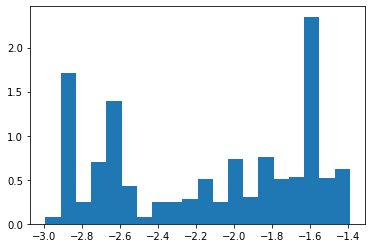

In [27]:
plt.hist(np.log(np.array(ls_list)), density = True, weights = np.array(w_list), bins = 20)

(array([0.01871348, 0.08091364, 0.09444995, 0.02274175, 0.06513396,
        0.09431404, 0.07068379, 0.12882575, 0.23294983, 0.13791918,
        0.20547646, 0.07543074, 0.03482492, 0.08028575, 0.11251773,
        0.04861215, 0.04120013, 0.21601423, 0.14031551, 0.10253068]),
 array([ 5.01325933,  5.51229776,  6.01133619,  6.51037463,  7.00941306,
         7.50845149,  8.00748992,  8.50652835,  9.00556678,  9.50460522,
        10.00364365, 10.50268208, 11.00172051, 11.50075894, 11.99979737,
        12.49883581, 12.99787424, 13.49691267, 13.9959511 , 14.49498953,
        14.99402796]),
 <BarContainer object of 20 artists>)

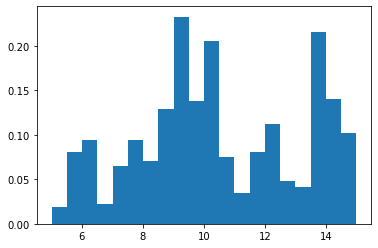

In [28]:
plt.hist(np.array(sg_list), density = True, weights = np.array(w_list), bins = 20)

(array([9.52720150e+01, 2.03944856e+01, 8.77487121e+00, 3.10468546e-01,
        1.75914016e+00, 9.95835815e+00, 5.53852382e-02, 2.25237070e-01,
        2.57546936e+00, 3.43003302e-01, 1.17044079e+00, 2.15632881e-01,
        1.54131123e+00, 1.77171983e-01, 4.52147251e+00, 0.00000000e+00,
        9.76780681e-01, 6.12270805e-02, 9.13377100e-01, 8.36564825e-03]),
 array([6.21886218e-06, 6.70619721e-03, 1.34061756e-02, 2.01061539e-02,
        2.68061323e-02, 3.35061106e-02, 4.02060890e-02, 4.69060673e-02,
        5.36060457e-02, 6.03060240e-02, 6.70060024e-02, 7.37059807e-02,
        8.04059591e-02, 8.71059374e-02, 9.38059158e-02, 1.00505894e-01,
        1.07205873e-01, 1.13905851e-01, 1.20605829e-01, 1.27305808e-01,
        1.34005786e-01]),
 <BarContainer object of 20 artists>)

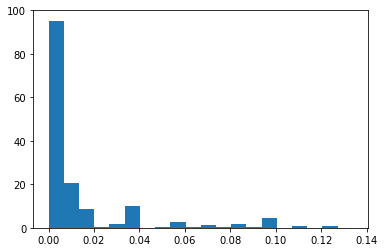

In [29]:
plt.hist(np.array(br_list), density = True, weights = np.array(w_list), bins = 20)

In [30]:
post_mean_params = { "base_rate" : np.dot(w_list,br_list)/np.sum(w_list),
                       "lengthscale" : np.exp(np.dot(w_list,np.log(ls_list))/np.sum(w_list)),
                       "gp_sigma" : np.dot(w_list,sg_list)/np.sum(w_list),
                       "gp_ridge" : .01,
            "gp_offset": -10.0
            }
post_mean_params

{'base_rate': 0.012720722323046245,
 'lengthscale': 0.11828734220636047,
 'gp_sigma': 10.48050398944492,
 'gp_ridge': 0.01,
 'gp_offset': -10.0}

In [31]:
sample = gen_batch_letters(germline, 10000, post_mean_params)

In [32]:
sample_bp = (1.0-np.mean(np.array(sample) == germline, axis = 0))

In [33]:
sample_colocal = get_colocal(sample,germline, sample_bp,50)

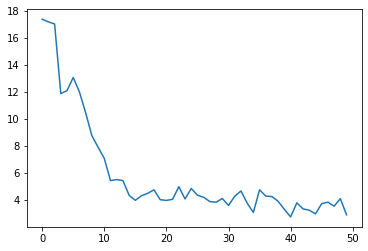

In [34]:
plt.plot(sample_colocal)

In [35]:
base_prob = (1.0-np.mean(seqs == np.array(list(germline)), axis = 0))
colocals = get_colocal(seqs,germline,base_prob,50)

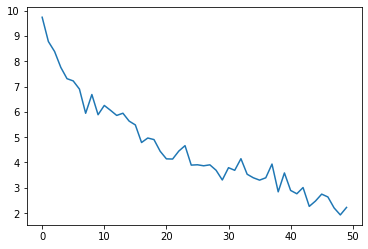

In [36]:
plt.plot(colocals)